In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Öncelikle gerekli kütüphaneleri içe aktarıyoruz. Burada, görüntü işleme için **ImageDataGenerator**, çeşitli makine öğrenme modelleri ve değerlendirme metriklerini kullanacağız. Ayrıca veri görselleştirmeleri için **matplotlib** ve **seaborn** kütüphanelerini kullanarak, sonuçları daha anlaşılır hale getireceğiz.



In [2]:
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setimizi tanımlıyoruz. Eğitim ve test verilerinin dizinlerini belirleyerek, bu verilerin yükleneceği yolları ayarlıyoruz.

In [3]:
train_dir = '/kaggle/input/breast-cancer-detection/train'
test_dir = '/kaggle/input/breast-cancer-detection/test'

# Görüntülerin boyutunu (64x64) ve **batch_sizei** ayarlıyoruz. Bu adımda, veri artırma kullanmadan sadece görüntüleri normalleştirmek için **ImageDataGenerator** kullanıyoruz. Bu, gözetimsiz modellerde kullanılacak.

In [4]:
image_size = (64, 64)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Eğitim ve test verilerini yükleyerek, her iki set için birer **generator** oluşturuyoruz. Burada önemli olan **class_mode=None** kullanmak, çünkü gözetimsiz öğrenme yapıyoruz ve etiketler kullanılmıyor.

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Gözetimsiz
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Gözetimsiz
    shuffle=False
)

Found 2372 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


# Test verisindeki gerçek etiketleri almak için .**classes** özelliğini kullanıyoruz. Bu özellik, her sınıfa atanan etiketleri döndürüyor.

In [6]:
test_labels = test_generator.classes

# Veriyi batch'ler halinde işlemek için bir fonksiyon yazıyoruz. Bu sayede bellek kullanımını optimize edebiliriz. **AgglomerativeClustering** algoritması için **fit_predict** kullanıyoruz, diğer modeller için ise **predict** fonksiyonunu çağırıyoruz.



In [7]:
def batch_processing(generator, model, is_agglomerative=False):
    predictions = []
    for i, batch in enumerate(generator):
        if i >= len(generator):
            break
        X_batch = batch.reshape(len(batch), -1)
        X_batch_scaled = scaler.transform(X_batch)
        
        if is_agglomerative:
            preds = model.fit_predict(X_batch_scaled)  # Agglomerative için fit_predict kullanıyoruz
        else:
            preds = model.predict(X_batch_scaled)
        
        predictions.extend(preds)
    
    return np.array(predictions)

# Veriyi ölçeklendirmek için **StandardScaler** kullanıyoruz. Böylece verilerimizin modelleme için daha uygun hale gelmesini sağlıyoruz.

In [8]:
scaler = StandardScaler()

# Şimdi gözetimsiz öğrenme modellerimizi tanımlıyoruz. Burada iki farklı model kullanıyoruz: **K-Means** ve **AgglomerativeClustering**. Bu modellerin her ikisini de aynı yapı üzerinde çalıştıracağız.

In [11]:
unsupervised_models = {
    'Hierarchical Clustering': AgglomerativeClustering(n_clusters=2),
    'K-Means': KMeans(n_clusters=2, random_state=42, n_init=10),
}

# Veriyi batch'ler halinde işleyerek düzleştiriyoruz. Görüntülerin 2D halinden 1D hale getirilmesi ve ardından ölçeklendirilmesi işlemi burada yapılıyor. Bu, verinin modeller tarafından işlenmesi için gerekli.

In [12]:
unsupervised_results = {}
X_train_batches = np.vstack([train_generator[i] for i in range(len(train_generator))])
X_train_flat = X_train_batches.reshape(len(X_train_batches), -1)
X_train_flat_scaled = scaler.fit_transform(X_train_flat)

# Her iki modelimizi eğitim verisi üzerinde eğitiyoruz ve ardından test verisindeki görüntüler üzerinde tahminler yapıyoruz. **AgglomerativeClustering** için **fit_predict**, diğer model için ise **predict** kullanıyoruz.

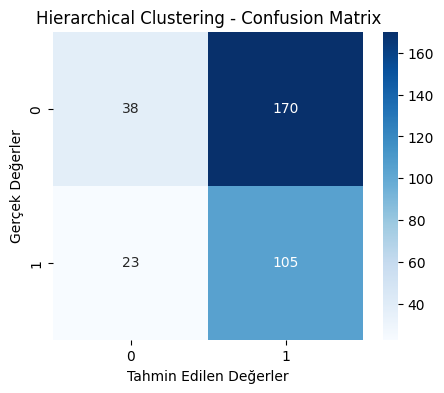


Hierarchical Clustering Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.18      0.28       208
           1       0.38      0.82      0.52       128

    accuracy                           0.43       336
   macro avg       0.50      0.50      0.40       336
weighted avg       0.53      0.43      0.37       336



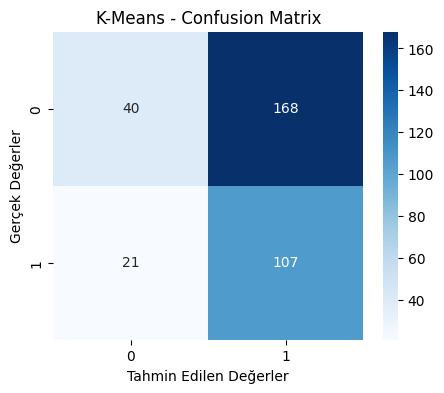


K-Means Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.19      0.30       208
           1       0.39      0.84      0.53       128

    accuracy                           0.44       336
   macro avg       0.52      0.51      0.41       336
weighted avg       0.55      0.44      0.39       336



In [13]:
for model_name, model in unsupervised_models.items():
    if hasattr(model, 'fit'):
        model.fit(X_train_flat_scaled)

    is_agglomerative = model_name == 'Hierarchical Clustering'
    y_pred = batch_processing(test_generator, model, is_agglomerative)

    if np.bincount(y_pred.astype(int))[0] != np.bincount(test_labels)[0]:
        y_pred = 1 - y_pred  # 0 ve 1'i tersine çeviriyoruz

    precision = precision_score(test_labels, y_pred, zero_division=0)
    recall = recall_score(test_labels, y_pred, zero_division=0)
    f1 = f1_score(test_labels, y_pred, zero_division=0)
    accuracy = accuracy_score(test_labels, y_pred)
    cm = confusion_matrix(test_labels, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahmin Edilen Değerler')
    plt.show()
    
    unsupervised_results[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }

    print(f"\n{model_name} Classification Report:")
    print(classification_report(test_labels, y_pred, zero_division=0))

# Şimdi gözetimsiz öğrenme modellerimizin sonuçlarını topluyoruz ve her bir modelin doğruluk, hassasiyet, geri çağırma ve F1 skorlarını görüntülüyoruz.

In [14]:
print("\nGözetimsiz Modeller Sonuçları:")
for model, result in unsupervised_results.items():
    print(f"{model}: {result}")


Gözetimsiz Modeller Sonuçları:
Hierarchical Clustering: {'Precision': 0.38181818181818183, 'Recall': 0.8203125, 'F1 Score': 0.5210918114143921, 'Accuracy': 0.4255952380952381}
K-Means: {'Precision': 0.3890909090909091, 'Recall': 0.8359375, 'F1 Score': 0.5310173697270472, 'Accuracy': 0.4375}


# Çapraz doğrulama (cross-validation) işlemi için **LogisticRegression** modelini tanımlıyoruz ve verileri 5 katlı çapraz doğrulama ile değerlendiriyoruz. Modelin her bir katmanındaki doğruluk sonuçlarını alıyoruz.

In [15]:
logreg_model = LogisticRegression(max_iter=5000)
y_train = train_generator.classes  
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(logreg_model, X_train_flat_scaled, y_train, cv=cv, scoring='accuracy')

print(f"\nÇapraz Doğrulama Skorları: {cv_scores}") 


Çapraz Doğrulama Skorları: [0.51789474 0.50947368 0.55907173 0.54852321 0.5907173 ]


# İlk olarak gerekli kütüphaneleri içe aktarıyoruz. Bu kütüphaneler, veri ön işleme, modelleme ve performans değerlendirmesi için kullanılıyor. Özellikle görüntü işleme ve modelleme için gerekli araçları sağlıyorlar.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Veri dizinlerini tanımlıyoruz. Bu dizinler eğitim, doğrulama (validation) ve test verileri için kullanılıyor. Her bir dizin, ilgili veri setinin bulunduğu yolu gösteriyor.

In [17]:
train_dir = '/kaggle/input/breast-cancer-detection/train'
valid_dir = '/kaggle/input/breast-cancer-detection/valid'
test_dir = '/kaggle/input/breast-cancer-detection/test'

# Görüntülerin boyutlarını (150x150) ve **batch_sizei** (32) ayarlıyoruz. **ImageDataGenerator** kullanarak görüntüleri ölçeklendiriyoruz. Eğitim, doğrulama ve test veri setlerini yüklemek için bu ayarları yapıyoruz.

In [18]:
image_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2372 images belonging to 2 classes.
Found 675 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


# Veri işleme fonksiyonu yazıyoruz. Bu fonksiyon, görüntüleri düzleştirir ve standartlaştırır. Eğitim ve test veri setlerini bu işleme tabi tutarak, modelin girişine uygun hale getiriyoruz.

In [19]:
def flatten_and_scale(generator):
    images, labels = [], []
    for batch_images, batch_labels in generator:
        images.append(batch_images)
        labels.append(batch_labels)
        if generator.batch_index == generator.samples // generator.batch_size:
            break
    all_images = np.concatenate(images, axis=0)
    all_labels = np.concatenate(labels, axis=0)

    # Görüntüleri düzleştirme
    all_images_flat = np.reshape(all_images, (len(all_images), -1))
    
    # Standartlaştırma (StandardScaler)
    scaler = StandardScaler()
    all_images_scaled = scaler.fit_transform(all_images_flat)
    
    return all_images_scaled, all_labels

# Eğitim ve test veri setlerini işliyoruz. Düzleştirme ve standartlaştırma işlemini gerçekleştiriyoruz. Bu, modelin verileri daha verimli bir şekilde işleyebilmesi için gerekli.

In [22]:
X_train_flat_scaled, y_train = flatten_and_scale(train_generator)
X_test_flat_scaled, y_test = flatten_and_scale(test_generator)

# Gözetimli öğrenme modellerimizi tanımlıyoruz. Burada, Logistic Regression ve Decision Tree modellerini kullanacağız. Her iki model de sınıflandırma problemi için uygun seçeneklerdir.

In [24]:
supervised_models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
}

# Modelleri eğitiyoruz ve test verileri üzerinde performanslarını değerlendiriyoruz. Performans metrikleri olarak hassasiyet, geri çağırma, F1 skoru, doğruluk, ortalama kare hata (MSE) ve ortalama mutlak hata (MAE) kullanıyoruz. Ayrıca karışıklık matrisini görselleştiriyoruz.

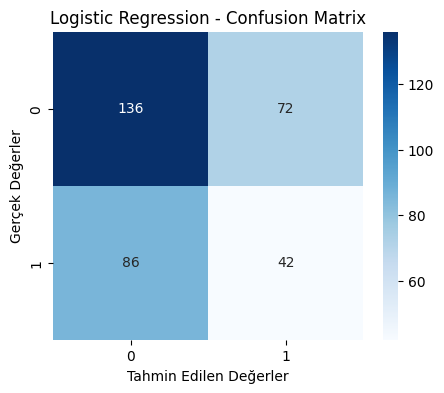


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       208
         1.0       0.37      0.33      0.35       128

    accuracy                           0.53       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.52      0.53      0.52       336



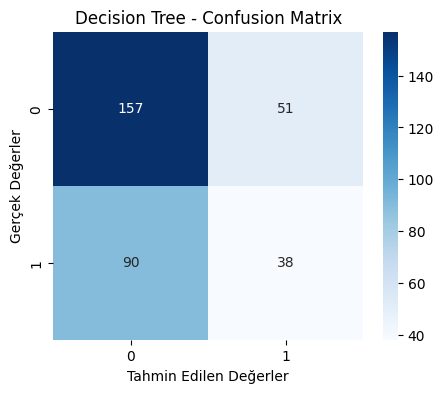


Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.75      0.69       208
         1.0       0.43      0.30      0.35       128

    accuracy                           0.58       336
   macro avg       0.53      0.53      0.52       336
weighted avg       0.56      0.58      0.56       336



In [25]:
supervised_results = {}

for model_name, model in supervised_models.items():
    model.fit(X_train_flat_scaled, y_train)
    y_pred = model.predict(X_test_flat_scaled)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Karışıklık Matrisi
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('Gerçek Değerler')
    plt.xlabel('Tahmin Edilen Değerler')
    plt.show()
    
    supervised_results[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae
    }
    
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# Sonuçları yazdırıyoruz. Her bir modelin performansını ve değerlendirme metriklerini görüntülüyoruz.

In [26]:
print("\nGözetimli Modeller Sonuçları:")
for model, result in supervised_results.items():
    print(f"{model}: {result}")


Gözetimli Modeller Sonuçları:
Logistic Regression: {'Precision': 0.3684210526315789, 'Recall': 0.328125, 'F1 Score': 0.3471074380165289, 'Accuracy': 0.5297619047619048, 'Mean Squared Error': 0.4702381, 'Mean Absolute Error': 0.4702381}
Decision Tree: {'Precision': 0.42696629213483145, 'Recall': 0.296875, 'F1 Score': 0.35023041474654376, 'Accuracy': 0.5803571428571429, 'Mean Squared Error': 0.41964287, 'Mean Absolute Error': 0.41964287}


# çapraz doğrulama kullanarak, modelin doğruluk skorlarını değerlendiriyoruz. Çapraz doğrulama skorlarının ortalamasını da hesaplıyoruz.

In [27]:
logreg_model = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced')
cv = StratifiedKFold(n_splits=3)
cv_scores = cross_val_score(logreg_model, X_train_flat_scaled, y_train, cv=cv, scoring='accuracy')
print(f"Ortalama Çapraz Doğrulama Skoru: {cv_scores.mean()}")

Ortalama Çapraz Doğrulama Skoru: 0.5396203065072785
